---
layout: default
title: "Deep Learning - CNN - YOLO"
categories: deeplearning
permalink: /ML38/
order: 38
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from plot_ann import ann
plt.rcParams["mathtext.fontset"] = "cm"
import pandas as pd
import sklearn.datasets
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Rectangle

Populating the interactive namespace from numpy and matplotlib


# You Only Look Once
While the convolutional implementation of the sliding window is more computationally efficient that running a CNN independently for each step of a classic sliding window approach, it has the problem of outputting inaccurate bounding boxes. Suppose our convolutional localization algorithm takes as input a series of windows but none of them really matches ground truth (A) and maybe the best one (B) is as the one in <a href="#fig:bboxes">the figure below</a>. The [**YOLO**](https://arxiv.org/abs/1506.02640) algorithm allows to increase the accuracy of predicted bounding boxes. 

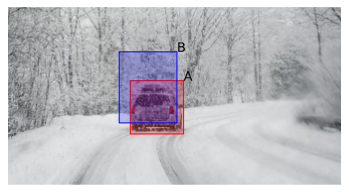

In [2]:
fig, ax = plt.subplots()
img = plt.imread('./data/img/car.jpg')
ax.imshow(img)
yrect = Rectangle((275, 165), 120, 120, facecolor=(1, 0, 0, 0.2), edgecolor='r')
prect = Rectangle((250, 100), 130, 160, facecolor=(0, 0, 1, 0.2), edgecolor='b')
ax.add_artist(yrect)
ax.add_artist(prect)
ax.text(1, 0, 'A', transform=yrect.get_transform(), fontsize=13)
ax.text(1, 0, 'B', transform=prect.get_transform(), fontsize=13)
ax.set_axis_off()

<i id="fig:bboxes">Labelled (A) and predicted (B) bounding boxes localizing a car in a picture</i>

The YOLO (**You Only Look Once**) algorithm functions by applying a grid to the input image. In <a href="#fig:yologrid">the figure below</a> we divide the input image in a $4 \times 4$ grid although in an actual implementation a finer grid is usually employed as for example a $19 \times 19$ grid. The basic idea of the YOLO algorithm is to apply the image classification and localization algorithm to each cell in the grid. 

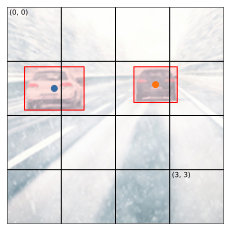

In [25]:
fig, ax = plt.subplots()
img = plt.imread('./data/img/cars.jpg')
img = img[:, 120:-106, :]
img.shape
ax.imshow(img)
r1 = Rectangle((16, 55), 55, 40, facecolor=(1, 0, 0, 0.1), edgecolor='r')
r2 = Rectangle((117, 55), 40, 33, facecolor=(1, 0, 0, 0.1), edgecolor='r')
ax.scatter((16*2+55)/2, (55*2+40)/2)
ax.scatter((117*2+40)/2, (55*2+33)/2)
ax.add_artist(r1)
ax.add_artist(r2)
for coord in np.arange(0, 250, 50):
    ax.axvline(coord, c='k', lw=1)
    ax.axhline(coord, c='k', lw=1)

ax.text(.01, .99, '(0, 0)', fontsize=7, va='top', transform=ax.transAxes)
ax.text(.76, .24, '(3, 3)', fontsize=7, va='top', transform=ax.transAxes)

ax.set_xlim(0, 200)
ax.set_ylim(200, 0)

ax.set_axis_off()

<i id="fig:yologrid">An image subdivided in a $4 \times 4$ grid for the YOLO algorithm. A cell contains a bounding box only if it hosts its midpoint</i>

For each grid cell you will have an output vector  $\hat{y} \in \mathbb{R}^{8 \times 1}$. The whole grid will define an output volume whose shape (given a $4 \times 4$ grid) will be $4 \times 4 \times 8$.

A neural network with YOLO architecture will have an input image (suppose a $100 
\times 100 \times 3$), fed to a typical convolutional network with an alternance of CONV layers and POOL layers (usually max-pooling ones), which processes the input up to the point of obtaining a $4 \times 4 \times 8$ output volume (or any other grid-size), so that it can be trained with images labeled as in $\eqref{eq:yolotrain}$.

This approach tries to simplify the object detection problem back to the object localization problem by splitting it in sub-problems.
As we have seen for the localization object detection algorithm, to train each grid cell the label vector $y \in \mathbb{R}^{8 \times 1}$

$$
\begin{equation}
y = 
\begin{bmatrix} 
P_c \\
b_x \\
b_y \\
b_h \\
b_w \\
c_1 \\
c_2 \\ 
c_3 \\
\end{bmatrix}
\end{equation}
\label{eq:yolotrain} \tag{1}
$$

where $p_c$ is a label indicating the presence ($p_c=1$) or absence ($p_c=0$) of any object in the grid cell, $b_x$, $b_y$ are the coordinates of the middle-point of the bounding box, $b_h, b_w$ are the height and width of the bounding box and $c_1, c_2, c_3$ are three different object classes (e.g. car, motorcycle or pedestrian). An object is assigned to a cell ($p_c=1$) if the midpoint of its bounding box falls in that cell. So, if a cell contains a portion of a bounding box but not its midpoint it is labeled as background ($p_c=0$). For example the label vectors for grid cells in <a href="#fig:yologrid">the figure above</a> are

$$
y_{0,n} = y_{1, 1} = y_{1, 3} = y_{2,n} = y_{3,n} =
\begin{bmatrix} 
0 \\
? \\
? \\
? \\
? \\
? \\
? \\ 
? \\
\end{bmatrix} \qquad \qquad 
y_{1, 0} = 
\begin{bmatrix} 
1 \\
\color{blue}{b_x} \\
\color{blue}{b_y} \\
\color{blue}{b_h} \\
\color{blue}{b_w} \\
1 \\
0 \\ 
0 \\
\end{bmatrix}
\qquad \qquad
y_{1, 3} = 
\begin{bmatrix} 
1 \\
\color{orange}{b_x} \\
\color{orange}{b_y} \\
\color{orange}{b_h} \\
\color{orange}{b_w} \\
1 \\
0 \\ 
0 \\
\end{bmatrix}
$$

The way bounding box dimensions ($b_w, b_h$) and position ($b_x, b_y$) are encoded is fractional and relative to the grid where the bounding box is in. Coordinates are defined by setting the top-left corner as the origin ($0,0$) and the bottom-right corner as the maximum ($1,1$). Width and height are defined as fraction of the overall width and overall height of the grid cell respectively. So, for the bounding box in <a href="#fig:bboxcoords">the figure below</a>, the label vector $y$ is:

$$
y_{1, 3} = 
\begin{bmatrix} 
1 \\
\color{orange}{b_x} \\
\color{orange}{b_y} \\
\color{orange}{b_h} \\
\color{orange}{b_w} \\
1 \\
0 \\ 
0 \\
\end{bmatrix}
= 
\begin{bmatrix} 
1 \\
\color{orange}{0.74} \\
\color{orange}{0.43} \\
\color{orange}{0.80} \\
\color{orange}{0.66} \\
1 \\
0 \\ 
0 \\
\end{bmatrix}
$$

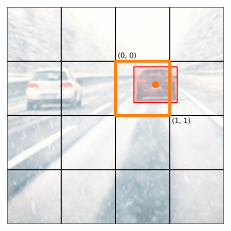

In [30]:
fig, ax = plt.subplots()
img = plt.imread('./data/img/cars.jpg')
img = img[:, 120:-106, :]
img.shape
ax.imshow(img)
r1 = Rectangle((100, 50), 50, 50, facecolor='none', edgecolor='C1', linewidth=3, zorder=1000)
r2 = Rectangle((117, 55), 40, 33, facecolor=(1, 0, 0, 0.1), edgecolor='r')
ax.scatter((117*2+40)/2, (55*2+33)/2, c='C1')
ax.add_artist(r1)
ax.add_artist(r2)
for coord in np.arange(0, 250, 50):
    ax.axvline(coord, c='k', lw=1)
    ax.axhline(coord, c='k', lw=1)

ax.text(.51, .76, '(0, 0)', fontsize=7, va='bottom', transform=ax.transAxes)
ax.text(.76, .49, '(1, 1)', fontsize=7, va='top', transform=ax.transAxes)

ax.set_xlim(0, 200)
ax.set_ylim(200, 0)

ax.set_axis_off()

<i id="fig:bboxcoords">The coordinate system for a bounding box are relative to the grid in which it is detected</i>

This coordinate system implies that the coordinates of the midpoint of the bounding box must be between 0 and 1 ($0 \leq b_x, b_y \leq 1$) but the size of the bounding box could be greater than 1, if the bounding box is bigger than the grid cell. This ensures that the size of the bounding box is independent of the size of the grid, which in turn allows to use a finer grid that is necessary for identifying a larger number of object in the same input image. 

While there are some more complex parametrization for bounding boxes that ensure better performance, this parametrization is reasonable in terms of simplicity and performance.

The advantage of this method is that the neural network outputs **precise bounding boxes**. For each grid cell, the algorithm will predict if there is or isn't an object ($p_c$), and the bounding box of the object. As long as each grid cell contains one object this algorithm will work well and a finer grid (as a typical $19 \times 19$ grid) drastically reduces the probability of having multiple objects in the same cell. Since the algorithm explicitly outputs the bounding box coordinates and dimensions enables to have precise coordinates and bounding boxes of any aspect ratio. Furthermore, this is a single convolutional implementation with a lot of shared computation that can output the precise location of multiple object in one single run.

The YOLO algorithm explained until now can be improved, by introducing 3 concepts:

* intersection over union
* nonmax suppression
* anchor boxes

## Intersection over union
Intersection over union can be used to evaluate an object detection algorithm and it is also instrumental to **nonmax suppression**. Suppose you have dataset of pictures labelled with the location of some objects (e.g. cars). Suppose that you develop a CNN that localizes cars trained on that dataset and once run, you have a ground truth bounding box (A) and a predicted bounding box (B) as in <a href="#fig:bboxes">the figure below</a>. How do you compare a predicted bounding box (B) against the ground truth (A)?

To evaluate bounding boxes we use an index called **intersection over union**, which is a measure of the overlap between two bounding boxes:

$$
\text{IoU} = \frac{A \cap B}{A \cup B} 
$$

By convention many localization tasks will evaluate an answer as correct if $\text{IoU} \geq 0.5$.

## Nonmax suppression
One of the problems of object detection is that your algorithm may detect the same object multiple times; non-max suppression ensures that each object is detected only once.

Since the image classification and localization algorithm is virtually running for each cell, it is possible that the value of $p_c$ for many of them is above threshold for triggering detection. Non-max suppression cleans up these multiple detections preventing multiple detections per objects: for each object it only keeps the bounding box with the highest probability, where the probability is $p_c$ multiplied by the probability of the specific object $c_n$ (in our example $c_1$, $c_2$ or $c_3$).

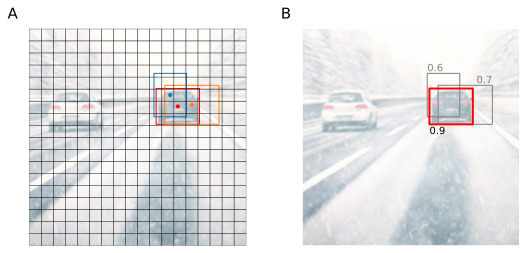

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax1, ax2 = axes

img = plt.imread('./data/img/cars.jpg')
img = img[:, 120:-106, :]

ax1.add_artist(Rectangle((117, 55), 40, 33, facecolor='none', edgecolor='r'))
ax2.add_artist(Rectangle((117, 55), 40, 33, facecolor='none', edgecolor='r', lw=2, zorder=100))

ax1.scatter([(117*2+40)/2, 130, 150], [(55*2+33)/2, 61, 70], c=['r', 'C0', 'C1'], s=10)

ax1.add_artist(Rectangle((130-15, 61-20), 30, 40, facecolor='none', edgecolor='C0'))
ax2.add_artist(Rectangle((130-15, 61-20), 30, 40, facecolor='none', edgecolor='grey'))

ax1.add_artist(Rectangle((150-25, 70-18), 50, 36, facecolor='none', edgecolor='C1'))
ax2.add_artist(Rectangle((150-25, 70-18), 50, 36, facecolor='none', edgecolor='grey'))

ax2.text(117, 90, '0.9', va='top')
ax2.text(175, 50, '0.7', ha='right', c='grey')
ax2.text(115, 39, '0.6', c='grey')

coords = np.linspace(0, 200, 19)

for coord in coords:
    ax1.axvline(coord, c='k', lw=.5)
    ax1.axhline(coord, c='k', lw=.5)

for ax, l in zip(axes, 'AB'):
    ax.text(-.1, 1.1, l, transform=ax.transAxes, fontsize=15, va='top')
    ax.imshow(img)
    ax.set_xlim(0, 200)
    ax.set_ylim(200, 0)
    ax.set_axis_off()

<i id="fig:nonmax">Multiple grid cells with predicted bounding middle-points in them (A). Multiple bounding box with their associated $p_c$ (B): only the one with the highest value $p_c$ (red edge) is kept while the others (gray edge) are suppressed by non-max suppression</i>

Non-max suppression works by processing the $19 \times 19 \times 8$ output volume of the YOLO network, where each $8 \times 1$ vector is as in $\eqref{eq:yolotrain}$). For this example we will simplify the output to the case where the network only detects one object so that we can get rid of the $c_1, c_2, c_3$ values and only consider the output vector

$$
\hat{y}=\begin{bmatrix}
p_c\\ b_x\\ b_y\\ b_h\\ b_w
\end{bmatrix}
$$

Non-max suppression works by first removing all bounding boxes with $p_c \leq t$, where $t$ is some threshold (usually $0.6$). For each bounding box that hasn't been either selected or suppressed:

* Pick the bounding box with the largest $p_c$
* Discard any other bounding boxes with $\text{IoU} \geq 0.5$ with the bounding box picked in the previous step

In this example we used the simpler case in which there only is one object class, when multiple object classes are present, the non-max suppression algorithm needs to be run independently for each class, to prevent suppression to discard bounding boxes of other classes respect to the one evaluated. Furthermore, when multiple object classes are present, the bounding box selection is based on $p_c \cdot c$, where $c$ is the probability of detection of the individual class evaluated. 

## Anchor boxes
The YOLO architecture seen until this point enables each grid cell to detect only one object. In order to render a single cell to detect multiple objects **anchor boxes** are employed.

Consider the example in panel A of <a href="#fig:anchorboxes">the figure below</a>, where the midpoint of the bounding boxes of two objects fall in the same grid cell. The implementation seen until now would have to choose one of the two objects. To work around this issue, you can pre-define a set of shapes, called anchor boxes, that will allow to associate to each cell a number of bounding box predictions, one for each anchor box. In the example in panel B of <a href="#fig:anchorboxes">the figure below</a> two anchor boxes are defined, where in an actual implementation 5 or more anchor boxes are usually employed. In early times of anchor boxes, they were usually manually selected, while more advanced techniques involve clustering by k-means algorithm the type of anchor boxes and associated each cluster to the most common class that it represent. 

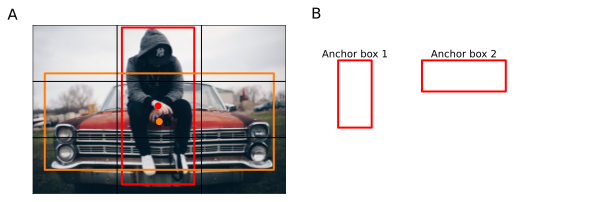

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
img = plt.imread('./data/img/anchor.jpeg')
ax1, ax2 = axes
ax1.imshow(img)
h, w, _ = img.shape

for ax, l in zip(axes, 'AB'):
    ax.text(-0.1, 1.1, l, transform=ax.transAxes, va='top', fontsize=15)
    ax.set_axis_off()

for x in np.linspace(0, w, 4):
    ax1.axvline(x, c='k', lw=1)

for y in np.linspace(0, h, 4):
    ax1.axhline(y, c='k', lw=1)

ax1.set_xlim(0, w)
ax1.set_ylim(h, 0)

ax1.add_artist(Rectangle((370, 10), 300, 650, facecolor='none', edgecolor='r', lw=2))
ax1.add_artist(Rectangle((50, 200), 950, 400, facecolor='none', edgecolor='C1', lw=2))
ax1.scatter(1040/2, 670/2, c='r')
ax1.scatter(1050/2, 800/2, c='C1');

ax2.set_aspect(h/w-.05)
ax2.add_artist(Rectangle((0, 0), 20, 65, facecolor='none', edgecolor='r', lw=2))
ax2.add_artist(Rectangle((50, 35), 50, 30, facecolor='none', edgecolor='r', lw=2))
ax2.text(10, 66, 'Anchor box 1', va='bottom', ha='center')
ax2.text(75, 66, 'Anchor box 2', va='bottom', ha='center')
ax2.set_xlim(-1, 150)
ax2.set_ylim(-65, 100);

<i id="fig:anchorboxes">Two objects (belonging to different classes) have their bounding box midpoints in the same grid cell (A). Two anchor boxes, with aspect ratio similar to that of the man and of the car respectively, are defined to allow detection of multiple objects in the same grid cell (B).</i>

To define anchor boxes the label vector $y$ needs to repeat the values in $\eqref{eq:yolotrain}$ for each anchor box. So, for two anchor boxes, predicting 3 classes of objects ($c_1, c_2, c_3$), $y$ is defined as

$$
y = \begin{bmatrix} 
p_c \\ b_x \\ b_y \\ b_w \\ b_h \\ c_1 \\ c_2 \\ c_3 \\
p_c \\ b_x \\ b_y \\ b_w \\ b_h \\ c_1 \\ c_2 \\ c_3 \\
\end{bmatrix}
\begin{array}{r}
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 1} \\
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 2}
\end{array}
$$


where the first set of 8 values will encode for one anchor box and the second set for another anchor box. So where previously each object in a training image was just assigned to the grid that contains the object bounding box midpoint, when the concept of anchor boxes is added to the architecture, training images also need to be labeled for anchor boxes: each object is assigned to the anchor box with the highest $\text{IoU}$ with the object bounding box. So whereas before each object was assigned to a grid cell, now **each object is assigned to the pair (grid cell,anchor box)**. So, given a $3 \times 3$ grid, 2 anchor boxes and 3 classes, the label $y$ and output $\hat{y}$ is going to be $3 \times 3 \times 2 \times 8$ (or $3 \times 3 \times 16$).

So for the example in panel A of <a href="#fig:anchorboxes">the figure above</a>, the label vector $y$ would be along the lines of

$$
y = \begin{bmatrix} 
1 \\ b_x \\ b_y \\ b_w \\ b_h \\ 1 \\ 0 \\ 0 \\
1 \\ b_x \\ b_y \\ b_w \\ b_h \\ 0 \\ 1 \\ 0 \\
\end{bmatrix}
\begin{array}{r}
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 1} \\
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 2}
\end{array}
$$

while in case one of the object types is not in the grid cell, the portion of $y$ corresponding to the anchor box that is most similar to that class $p_c=0$. Suppose the person is missing, we would have:

$$
y = \begin{bmatrix} 
0 \\ ? \\ ? \\ ? \\ ? \\ ? \\ ? \\ ? \\
1 \\ b_x \\ b_y \\ b_w \\ b_h \\ 0 \\ 1 \\ 0 \\
\end{bmatrix}
\begin{array}{r}
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 1} \\
\left. \begin{array}{r}
\\ \\ \\ \\ \\ \\ \\ \\
\end{array}
\right\}\text{Anchor box 2}
\end{array}
$$

## YOLO algorithm
We now have all the instrument to fully define the YOLO algorithm. Suppose that we have a $4 \times 4$ grid as in <a href="#fig:yologrid">the first figure</a>, that we want to detect 3 classes: pedestrian ($c_1$), car ($c_2$) and motorcycle ($c_3$), and that we define 2 anchor boxes. We would then have a $4 \times 4 \times 2 \times 8$ label vector $y$ that can also be represented as a $4 \times 4 \times 16$ vector. For our labeled training set, we define one of these vectors for each grid cell, for each input image. To train our network we input $100 \times 100 \times 3$ input images and fed them to a convolutional network whose final output has shape $4 \times 4 \times 16$.

Once trained, given an image the algorithm produces a $4 \times 4 \times 16$ volume. Then nonmax suppression is applied to the output: since we have 2 anchor boxes, for each grid cell, the algorithm produces 2 bounding boxes. Some of them will have very low $p_c$ but will be outputted anyway. All bounding boxes with $p_c$ below a pre-defined threshold are discarded. Finally for each class ($c_1, c_2 ,c_3$) we independently run nonmax suppression to generate the final prediction.

# Region Proposal
In the body of work about object detection an influential idea that has been proposed but is somehow overshadowed by YOLO-related implementations is **region proposal**. One of the classic region proposal algorithm is called R-CNN.

In a classic sliding window algorithm we would roll a sliding window across the whole input image, starting from the top-left corner all the way to the bottom-right corner. While we have seen that a convolutional implementation of the sliding window exists, it remains the problem that most of the windows analyzed will contain uninteresting data. 

In an R-CNN a segmentation filter is first applied to the input image to detect different areas on the image (panel B of <a href="#fig:semseg">figure below</a>). This segmentation step produces a number of blobs (usually some thousands). Bounding box are draw around each of these blobs and an object detection algorithm tries to detect objects inside the bounding box.

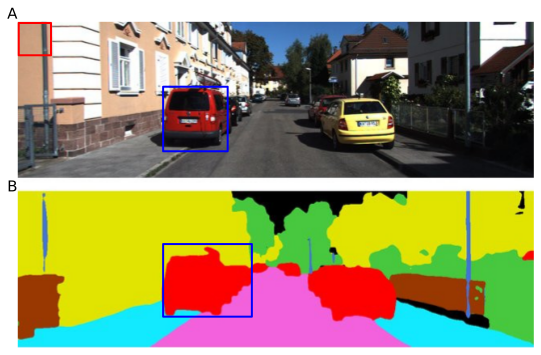

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))
img=plt.imread('./data/img/semseg.jpg')
ax.imshow(img)
ax.set_axis_off()
ax.text(-0.02, 1, "A", va='bottom', transform=ax.transAxes, fontsize=15)
ax.text(-0.02, .47, "B", va='bottom', transform=ax.transAxes, fontsize=15)
ax.add_artist(Rectangle((1, 1), 40, 40, fc='none', ec='r', lw=2))
ax.add_artist(Rectangle((180, 80), 80, 80, fc='none', ec='b', lw=2))
ax.add_artist(Rectangle((180, 275), 110, 90, fc='none', ec='b', lw=2))

<i id="fig:semseg">An example of a very precise semantic segmentation (B) achieved using 3D-data from a LiDAR and a video feed from a moving car (A). In a classic sliding window approach (convolutional or not) most of the windows will contain uninteresting data (red bounding box), while only some areas will actually contain an object (blue bounding box)</i>

This method hugely reduces the number of analyzed windows compared to running a sliding window algorithm (even convolutional), however it is still rather slow and there has been much work to create faster region proposal algorithms:

* The [R-CNN](https://arxiv.org/abs/1311.2524) propose regions and classify each region on at a time. It produce the output label and a bounding box. In fact R-CNN doesn't trust the bounding box that it is provided with and instead tries to define its own. Its downside is that it is slow and computationally heavy
* [Fast R-CNN](https://arxiv.org/abs/1504.08083) is a faster implementation of the R-CNN algorithm that also propose regions but, contrary to the classic R-CNN method, uses a convolutional implementation of the sliding window to classify all the proposed regions. While being faster than R-CNN, the region proposal step still is slow
* [Faster R-CNN](https://arxiv.org/pdf/1506.01497) uses convolutional netwrok to propose regions instead of a semantic segmentation algorithm. While being significantly faster than the Fast R-CNN method, it still is slower than the YOLO algorithm.